### HW recap and setup

In this homework you will try out semi-supervised learning using K-Means as we did in the lecture.

Use the seed 0 everywhere.

1. Import MNIST data as we did in Lecture 7. We are only going to use digits 0 and 1. So extract only those examples and discard the rest.

Next, randomly split the data into 80% training data and 20% testing data. Keep this split fixed throughout the experiments.

2. For each K in Ks=[10,20,30], follow the steps in the lecture:

    1. Cluster the training set into K clusters. Then for each cluster, find the image closest to the centroid, called the representative images. Plot the K representative images and manually label these images. Train Logistic Regression with K training examples. Report the training and the test accuracy.

    2. Assign the labels of all instances based on the labels of the cluster centers (i.e., representative images). Train Logistic Regression with all training data using the propagated labels. Report the training and the test accuracy.

3. Comment on the observed performance for the different values of K.

In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

### 1. Import MNIST data ... use digits 0 and 1... randomly split the data into 80% training data and 20% testing data


Reading the data

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

X = mnist["data"]
Y = mnist["target"] 

Again, I'm stealing the code from class to plot the digits data base

In [3]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1 

    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Now let's make sure we know how to extract the 0's and 1's correctly

[0 1 1 1 1 0 1 1 0 0]
[1 0 0 1 0 1 0 0 1 1]
[0 1 1 0 0 0 1 1 1 1]
[0 1 1 0 0 0 0 1 1 1]
[1 0 0 1 1 1 0 1 1 1]


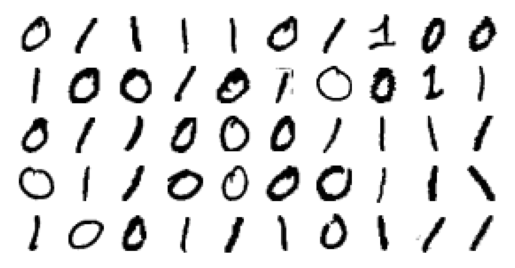

In [4]:
# mask of the 0's and 1's
mask_0_1 = ((Y==0) | (Y==1))
Y = Y[mask_0_1]
X = X[mask_0_1]
# let's check the first 50
for i in range(5):
    print(Y[i*10:i*10+10])
plot_digits(X[0:50])


That looks good. Now let's do the spliting. Same as previous HW, create a permutation and then take the first 80% for training and 20% for validation

In [5]:
m = len(Y)
np.random.seed(0)

# create a random index permutation
ind =np.array(range(0,m))
ind = np.random.permutation(ind)

# see some random indices
print(ind[0:20])

[ 9612  4447  8936  4006 13853  8900  5939  6204 10640  2192 11142 13199
  7327  1875 13076 11159  7186  3673 14488   214]


In [60]:
# 80% training, 20% testing
t_split = int(m*0.8)

train_ind = ind[0:t_split]
X_train = X[train_ind]
Y_train = Y[train_ind]

test_ind = ind[t_split:m]
X_test = X[test_ind]
Y_test = Y[test_ind]

### 2. For each K in Ks=[10,20,30], follow the steps in the lecture:

#### Step 1: Cluster the training set into K clusters. Then for each cluster, find the image closest to the centroid, called the representative images. Plot the K representative images and manually label these images. Train Logistic Regression with K training examples. Report the training and the test accuracy.

I start by making a function that finds the $k$ representative images for each k means clustering with their associated labels.

In [56]:
from sklearn.cluster import KMeans

def rep_images(k, X=X_train, Y=Y_train):
    # fit the k means to the train set
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    kmeans.cluster_centers_
    # find the index of the closest train elements to each cluster
    distances = kmeans.transform(X)
    closest_ind = []
    for i in range(k):
        closest_ind.append(np.argmin(distances[:,i]))
    return X[closest_ind], Y[closest_ind]

Now I plot the representatives for each of the $k$ clusters and show their labels (I don't know if that's what he meant by manually but I'm guessing is just to make sure they are okay)

In [57]:
Ks=[10, 20, 30]
X_rep = []
Y_rep = []
for k in Ks:
    xr, yr = rep_images(k)
    X_rep.append(xr)
    Y_rep.append(yr)

---------
 k=10
[1 0 1 0 1 0 0 0 1 0]
---------
 k=20
[0 1 0 1 1 0 0 0 1 0]
[0 1 0 0 0 0 1 1 0 1]
---------
 k=30
[0 1 0 0 1 0 1 0 1 1]
[0 0 1 0 0 0 1 1 0 1]
[0 0 0 0 0 0 1 0 1 1]


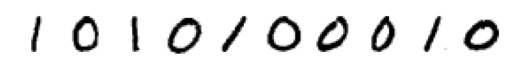

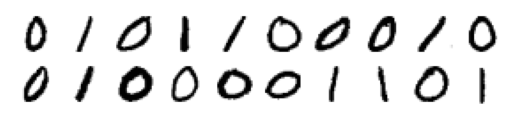

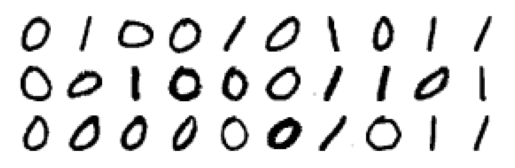

In [58]:
for j in range(3):
    plt.figure()
    plot_digits(X_rep[j])
    print("---------\n",f"k={Ks[j]}")
    for i in range(Ks[j]//10):
        print(Y_rep[j][i*10:i*10+10])

Finally, lets fit the logistic regression using these representatives for each $k$, and get the accuracy of the train and test sets.

Text(0.5, 1.0, 'accuracies')

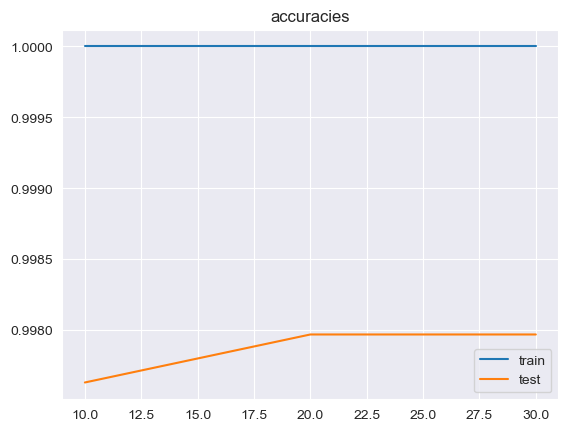

In [63]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns
sns.set_style("darkgrid")

accuracies_train = []
accuracies_test = []

for j in range(3):
    # fit 
    clf = LogisticRegression()
    clf.fit(X_rep[j],Y_rep[j])
    # train predict and score
    y_pred = clf.predict(X_rep[j])
    accuracies_train.append( accuracy_score(Y_rep[j],y_pred) )
    # test predict and score
    y_pred = clf.predict(X_test)
    accuracies_test.append( accuracy_score(Y_test,y_pred) )

# plot train and test accuracies
sns.lineplot(x=Ks,y=accuracies_train, label="train")
sns.lineplot(x=Ks,y=accuracies_test, label="test")
plt.title("accuracies")

### 3. Comment on the observed performance for the different values of K.

We see that the train accuracy is always $100\%$ which makes sense since we're using a very small set and the 0 and 1 digits are very distinguishable from each other. 

While the test accuracy is not $100\%$ it is still very close. It seems to improve from 10 to 20 but then stays stagnant from 20 to 30 maybe suggesting the limits of this loggistic regression model.

In [ ]:
print(accuracies_train)
print(accuracies_test)

[1.0, 1.0, 1.0]
[0.9976319350473613, 0.9979702300405954, 0.9979702300405954]
